# Teeth Segmentation with PyTorch U-Net
GPU-accelerated version using PyTorch

## 1. Setup and Imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

Using device: cuda
GPU: Quadro P2000
Memory: 5.00 GB


## 2. Download Dataset

In [2]:
from download_dataset import *
import os

path = "./Data"
if not os.path.exists(path + '/hxt48yk462-1.zip'):
    os.makedirs(path, exist_ok=True)
    download_dataset(path + '/')
    
else:
    print("Dataset already downloaded")
   

Dataset already downloaded


## 3. Prepare Images and Masks

In [3]:
from images_prepare import *

# Prepare images (resize to 512x512)
X, X_sizes = pre_images((512, 512), path, True)
print(f"Images shape: {X.shape}")

Images shape: (116, 512, 512, 1)


In [4]:
from masks_prepare import *

# Prepare masks - using custom splitted masks (512x512)
Y = pre_splitted_masks(path='./Custom_Masks')
print(f"Masks shape: {Y.shape}")

Masks shape: (116, 512, 512, 1)


## 4. Normalize Data

In [5]:
# Normalize to [0, 1]
X = np.float32(X / 255)
Y = np.float32(Y / 255)

print(f"X range: [{X.min()}, {X.max()}]")
print(f"Y range: [{Y.min()}, {Y.max()}]")

X range: [0.0, 1.0]
Y range: [0.0, 1.0]


## 5. Train/Test Split

In [6]:
# Split data (105 for training, rest for testing)
x_train = X[:105, :, :, :]
y_train = Y[:105, :, :, :]
x_test = X[105:, :, :, :]
y_test = Y[105:, :, :, :]

print(f"Training set: {x_train.shape}")
print(f"Test set: {x_test.shape}")

Training set: (105, 512, 512, 1)
Test set: (11, 512, 512, 1)


## 6. Visualize Data

Sample index: 75


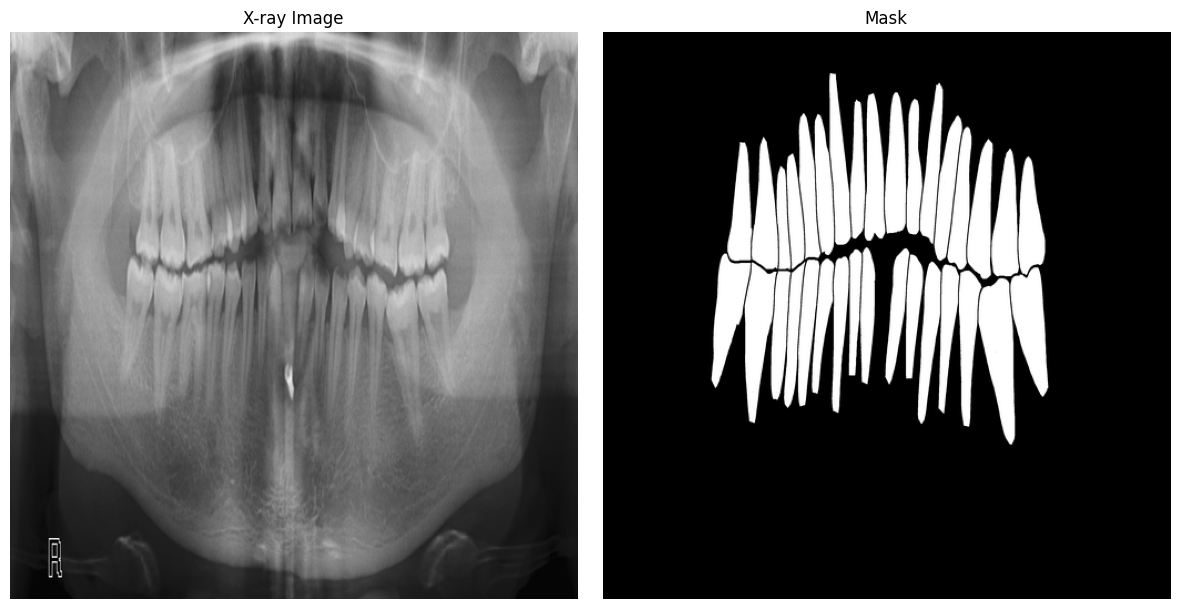

In [8]:
# Check data X and Y matching
random_number = random.randint(0, 104)
print(f"Sample index: {random_number}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(x_train[random_number, :, :, 0], cmap='gray')
ax1.set_title('X-ray Image')
ax1.axis('off')

ax2.imshow(y_train[random_number, :, :, 0], cmap='gray')
ax2.set_title('Mask')
ax2.axis('off')

plt.tight_layout()
plt.show()

## 7. Create Model

In [9]:
from model import UNET

# Create U-Net model
model = UNET(input_shape=(512, 512, 1), last_activation='sigmoid')
model = model.to(device)

# Print model summary
try:
    from torchinfo import summary
    summary(model, input_size=(1, 1, 512, 512))
except ImportError:
    print("Install torchinfo for model summary: pip install torchinfo")
    print(f"Model created successfully on {device}")

## 8. Train Model

In [ ]:
from train_pytorch import train_model

# Training parameters
BATCH_SIZE = 8
EPOCHS = 200
LEARNING_RATE = 0.001

# Train the model
model, history = train_model(
    x_train, y_train,
    x_test, y_test,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    device=device,
    save_path='unet_teeth_pytorch.pth'
)

Using device: cuda


c:\Users\user\anaconda3\envs\teeth_segmentation\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Starting training for 200 epochs...
Training samples: 105, Test samples: 11

Epoch 1/200
--------------------------------------------------


Training:   7%|▋         | 1/14 [00:13<02:56, 13.58s/it]

## 9. Load Trained Model (Optional)

In [ ]:
from train_pytorch import load_model

# Load a previously trained model
# model = load_model('unet_teeth_pytorch.pth', device=device)

## 10. Make Predictions

In [ ]:
from train_pytorch import predict

# Predict on test set
model.eval()
test_idx = 1

# Get prediction
predict_mask = predict(model, x_test[test_idx], device=device)

print(f"Prediction shape: {predict_mask.shape}")
print(f"Prediction range: [{predict_mask.min():.4f}, {predict_mask.max():.4f}]")

## 11. Visualize Predictions

In [ ]:
# Visualize prediction
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original image
axes[0].imshow(x_test[test_idx, :, :, 0], cmap='gray')
axes[0].set_title('Original X-ray')
axes[0].axis('off')

# Ground truth mask
axes[1].imshow(y_test[test_idx, :, :, 0], cmap='gray')
axes[1].set_title('Ground Truth Mask')
axes[1].axis('off')

# Predicted mask
axes[2].imshow(predict_mask, cmap='gray')
axes[2].set_title('Predicted Mask')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('prediction_result.png', dpi=150, bbox_inches='tight')
plt.show()

# Save predicted mask for CCA analysis
plt.imsave('predict.png', predict_mask)

## 12. Post-processing with CCA Analysis

In [ ]:
from CCA_Analysis import *

# Load original image (example with image 107)
img_path = "./Data/Images/107.png"
if os.path.exists(img_path):
    img = cv2.imread(img_path)
    
    # Load predicted mask
    predicted = cv2.imread('predict.png')
    
    # Resize to match original image
    predicted = cv2.resize(predicted, (img.shape[1], img.shape[0]), 
                          interpolation=cv2.INTER_LANCZOS4)
    
    # Apply CCA analysis
    cca_result, teeth_count = CCA_Analysis(img, predicted, 3, 2)
    
    # Display results
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(cca_result, cv2.COLOR_BGR2RGB))
    plt.title(f'CCA Analysis Result - {teeth_count} Teeth Detected')
    plt.axis('off')
    plt.savefig('cca_result.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Detected {teeth_count} teeth")
else:
    print(f"Image not found at {img_path}")

## 13. Batch Prediction (Optional)

In [ ]:
# Predict on multiple test images
num_samples = min(5, len(x_test))
fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))

for i in range(num_samples):
    pred = predict(model, x_test[i], device=device)
    
    axes[i, 0].imshow(x_test[i, :, :, 0], cmap='gray')
    axes[i, 0].set_title(f'Sample {i+1}: Original')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(y_test[i, :, :, 0], cmap='gray')
    axes[i, 1].set_title('Ground Truth')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(pred, cmap='gray')
    axes[i, 2].set_title('Prediction')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig('batch_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

## 14. GPU Memory Management

In [ ]:
# Clear GPU cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("GPU cache cleared")
    print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Reserved memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")